In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
import tensorflow.python.keras.engine
from keras.layers import *
from keras.models import Model
#from keras.preprocessing import imagecon
from tensorflow.keras.utils import load_img, img_to_array
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/My Drive/CNN-steg/data/tiny-imagenet-200.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

from keras.preprocessing import image

In [ ]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=100):
#def load_dataset_small():
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = load_img(os.path.join(c_dir, img_name_i))
            x = img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = load_img(os.path.join(test_dir, img_name_i))
        x = img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_test.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 100
X_train shape: (100, 64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]
print(input_S.shape)
# C: cover image
input_C = X_train[(X_train.shape[0] // 2):]
print(input_C.shape)

(1000, 64, 64, 3)
(1000, 64, 64, 3)


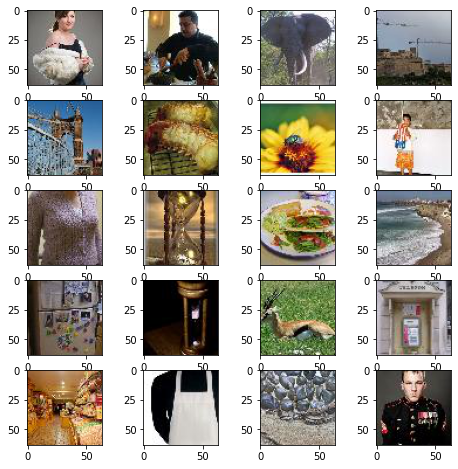

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    #s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    #s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    
    #s_loss = rev_loss(s_true, s_pred)
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
   
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    print(encoder.summary())
    decoder = make_decoder(input_size)
    print(decoder.summary())
    decoder.compile(optimizer='adam',loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    print(autoencoder.summary())
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_prep0_3x3 (Conv2D)        (None, 64, 64, 50)   1400        ['input_3[0][0]']                
                                                                                                  
 conv_prep0_4x4 (Conv2D)        (None, 64, 64, 10)   490         ['input_3[0][0]']                
                                                                                                  
 conv_prep0_5x5 (Conv2D)        (None, 64, 64, 5)    380         ['input_3[0][0]']                
                                                                                            

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
NB_EPOCHS = 10
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,y=batch_S)) 
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 1 | Batch:   0 of 1000. Loss AE   35697.74 | Loss Rev   24398.18:   3%|▎         | 1/32 [00:00<00:15,  1.97it/s]

1/1 [==============================] - 0s 63ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE   34927.66 | Loss Rev   24876.66:   6%|▋         | 2/32 [00:01<00:17,  1.70it/s]

1/1 [==============================] - 0s 109ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE   36604.08 | Loss Rev   26200.61:   9%|▉         | 3/32 [00:01<00:17,  1.65it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE   36943.26 | Loss Rev   27006.76:  12%|█▎        | 4/32 [00:02<00:14,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE   36185.83 | Loss Rev   26998.29:  16%|█▌        | 5/32 [00:02<00:12,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE   36222.97 | Loss Rev   27664.26:  19%|█▉        | 6/32 [00:02<00:11,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE   35031.35 | Loss Rev   27157.77:  22%|██▏       | 7/32 [00:03<00:10,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE   34571.08 | Loss Rev   26914.34:  25%|██▌       | 8/32 [00:03<00:09,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE   34367.94 | Loss Rev   27151.30:  28%|██▊       | 9/32 [00:04<00:09,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE   34006.79 | Loss Rev   27291.64:  31%|███▏      | 10/32 [00:04<00:08,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE   33563.18 | Loss Rev   27066.21:  34%|███▍      | 11/32 [00:04<00:07,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE   33133.64 | Loss Rev   26891.83:  38%|███▊      | 12/32 [00:05<00:07,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE   32898.71 | Loss Rev   26823.51:  41%|████      | 13/32 [00:05<00:07,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE   32872.90 | Loss Rev   27015.43:  44%|████▍     | 14/32 [00:05<00:06,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE   32825.43 | Loss Rev   27340.08:  47%|████▋     | 15/32 [00:06<00:06,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE   32746.84 | Loss Rev   27321.13:  50%|█████     | 16/32 [00:06<00:05,  2.71it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE   32804.48 | Loss Rev   27418.92:  53%|█████▎    | 17/32 [00:06<00:05,  2.70it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE   32599.13 | Loss Rev   27343.69:  56%|█████▋    | 18/32 [00:07<00:05,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE   32310.02 | Loss Rev   27330.22:  59%|█████▉    | 19/32 [00:07<00:04,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE   32269.49 | Loss Rev   27339.46:  62%|██████▎   | 20/32 [00:08<00:04,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE   32220.43 | Loss Rev   27371.20:  66%|██████▌   | 21/32 [00:08<00:04,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE   32291.46 | Loss Rev   27523.75:  69%|██████▉   | 22/32 [00:08<00:03,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE   32070.16 | Loss Rev   27357.94:  72%|███████▏  | 23/32 [00:09<00:03,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE   31989.76 | Loss Rev   27395.20:  75%|███████▌  | 24/32 [00:09<00:03,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE   31780.18 | Loss Rev   27340.89:  78%|███████▊  | 25/32 [00:10<00:02,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE   31675.04 | Loss Rev   27423.60:  81%|████████▏ | 26/32 [00:10<00:02,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE   31546.07 | Loss Rev   27405.76:  84%|████████▍ | 27/32 [00:10<00:01,  2.70it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE   31435.04 | Loss Rev   27333.92:  88%|████████▊ | 28/32 [00:11<00:01,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE   31353.30 | Loss Rev   27404.91:  91%|█████████ | 29/32 [00:11<00:01,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE   31220.98 | Loss Rev   27366.57:  94%|█████████▍| 30/32 [00:11<00:00,  2.72it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE   31145.01 | Loss Rev   27329.84:  97%|█████████▋| 31/32 [00:12<00:00,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE   30380.54 | Loss Rev   26692.23: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE   26290.24 | Loss Rev   26597.03:   3%|▎         | 1/32 [00:00<00:11,  2.76it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE   26313.75 | Loss Rev   26240.10:   6%|▋         | 2/32 [00:00<00:11,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE   27138.71 | Loss Rev   28590.96:   9%|▉         | 3/32 [00:01<00:10,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE   27445.54 | Loss Rev   28350.84:  12%|█▎        | 4/32 [00:01<00:10,  2.65it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE   27127.65 | Loss Rev   27813.48:  16%|█▌        | 5/32 [00:01<00:10,  2.70it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE   27041.48 | Loss Rev   27354.68:  19%|█▉        | 6/32 [00:02<00:09,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE   26720.21 | Loss Rev   26986.95:  22%|██▏       | 7/32 [00:02<00:10,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE   27224.05 | Loss Rev   27560.26:  25%|██▌       | 8/32 [00:03<00:09,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE   27099.92 | Loss Rev   27095.56:  28%|██▊       | 9/32 [00:03<00:08,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE   27365.36 | Loss Rev   27408.62:  31%|███▏      | 10/32 [00:03<00:08,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE   27437.33 | Loss Rev   27370.81:  34%|███▍      | 11/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE   27221.70 | Loss Rev   27104.99:  38%|███▊      | 12/32 [00:04<00:07,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE   27233.17 | Loss Rev   27037.12:  41%|████      | 13/32 [00:04<00:07,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE   27102.14 | Loss Rev   26941.29:  44%|████▍     | 14/32 [00:05<00:06,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE   27098.08 | Loss Rev   27134.40:  47%|████▋     | 15/32 [00:05<00:06,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE   27211.57 | Loss Rev   27305.96:  50%|█████     | 16/32 [00:06<00:05,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE   27224.83 | Loss Rev   27363.48:  53%|█████▎    | 17/32 [00:06<00:05,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE   27071.80 | Loss Rev   27275.87:  56%|█████▋    | 18/32 [00:06<00:05,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE   26985.68 | Loss Rev   27238.18:  59%|█████▉    | 19/32 [00:07<00:04,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE   26765.58 | Loss Rev   27025.43:  62%|██████▎   | 20/32 [00:07<00:04,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE   26722.75 | Loss Rev   27105.03:  66%|██████▌   | 21/32 [00:07<00:04,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE   26688.57 | Loss Rev   27047.22:  69%|██████▉   | 22/32 [00:08<00:03,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE   26769.24 | Loss Rev   27045.57:  72%|███████▏  | 23/32 [00:08<00:03,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE   26999.76 | Loss Rev   27247.60:  75%|███████▌  | 24/32 [00:09<00:02,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE   26962.44 | Loss Rev   27170.40:  78%|███████▊  | 25/32 [00:09<00:02,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE   26961.02 | Loss Rev   27203.73:  81%|████████▏ | 26/32 [00:09<00:02,  2.71it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE   26868.17 | Loss Rev   27119.85:  84%|████████▍ | 27/32 [00:10<00:01,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE   26842.91 | Loss Rev   27060.19:  88%|████████▊ | 28/32 [00:10<00:01,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE   26745.21 | Loss Rev   27008.31:  91%|█████████ | 29/32 [00:10<00:01,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE   26709.97 | Loss Rev   27007.02:  94%|█████████▍| 30/32 [00:11<00:00,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE   26735.49 | Loss Rev   27054.75:  97%|█████████▋| 31/32 [00:11<00:00,  2.63it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE   26113.80 | Loss Rev   26411.04: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE   25521.65 | Loss Rev   26137.62:   3%|▎         | 1/32 [00:00<00:14,  2.20it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE   24603.64 | Loss Rev   24587.81:   6%|▋         | 2/32 [00:00<00:12,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE   25049.13 | Loss Rev   25298.00:   9%|▉         | 3/32 [00:01<00:11,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE   26182.60 | Loss Rev   26988.54:  12%|█▎        | 4/32 [00:01<00:10,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE   25727.51 | Loss Rev   26533.37:  16%|█▌        | 5/32 [00:01<00:10,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE   25891.60 | Loss Rev   26274.71:  19%|█▉        | 6/32 [00:02<00:10,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE   25935.23 | Loss Rev   26605.24:  22%|██▏       | 7/32 [00:02<00:09,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE   25811.57 | Loss Rev   26656.00:  25%|██▌       | 8/32 [00:03<00:09,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE   25759.55 | Loss Rev   26756.51:  28%|██▊       | 9/32 [00:03<00:08,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE   25715.13 | Loss Rev   26827.48:  31%|███▏      | 10/32 [00:03<00:08,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE   25913.76 | Loss Rev   27073.76:  34%|███▍      | 11/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE   25787.99 | Loss Rev   26987.17:  38%|███▊      | 12/32 [00:04<00:07,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE   25577.96 | Loss Rev   26817.10:  41%|████      | 13/32 [00:04<00:07,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE   25551.89 | Loss Rev   26832.13:  44%|████▍     | 14/32 [00:05<00:06,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE   25453.85 | Loss Rev   27038.99:  47%|████▋     | 15/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE   25465.08 | Loss Rev   27252.06:  50%|█████     | 16/32 [00:06<00:06,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE   25453.20 | Loss Rev   27094.06:  53%|█████▎    | 17/32 [00:06<00:05,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE   25554.05 | Loss Rev   27282.88:  56%|█████▋    | 18/32 [00:06<00:05,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE   25617.56 | Loss Rev   27397.54:  59%|█████▉    | 19/32 [00:07<00:05,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE   25474.26 | Loss Rev   27389.87:  62%|██████▎   | 20/32 [00:07<00:04,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE   25534.99 | Loss Rev   27453.78:  66%|██████▌   | 21/32 [00:08<00:04,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE   25646.38 | Loss Rev   27466.99:  69%|██████▉   | 22/32 [00:08<00:03,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE   25569.95 | Loss Rev   27431.42:  72%|███████▏  | 23/32 [00:08<00:03,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE   25582.71 | Loss Rev   27400.31:  75%|███████▌  | 24/32 [00:09<00:03,  2.57it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE   25518.54 | Loss Rev   27305.52:  78%|███████▊  | 25/32 [00:09<00:02,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE   25633.63 | Loss Rev   27396.22:  81%|████████▏ | 26/32 [00:10<00:02,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE   25594.20 | Loss Rev   27313.49:  84%|████████▍ | 27/32 [00:10<00:01,  2.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE   25594.86 | Loss Rev   27310.35:  88%|████████▊ | 28/32 [00:10<00:01,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE   25598.67 | Loss Rev   27398.81:  91%|█████████ | 29/32 [00:11<00:01,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE   25623.36 | Loss Rev   27420.92:  94%|█████████▍| 30/32 [00:11<00:00,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE   25673.75 | Loss Rev   27541.62:  97%|█████████▋| 31/32 [00:12<00:00,  2.57it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE   25061.90 | Loss Rev   26882.11: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE   24631.91 | Loss Rev   25903.18:   3%|▎         | 1/32 [00:00<00:12,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE   24107.72 | Loss Rev   25271.07:   6%|▋         | 2/32 [00:00<00:11,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE   25343.60 | Loss Rev   27099.18:   9%|▉         | 3/32 [00:01<00:11,  2.56it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE   24979.56 | Loss Rev   27350.75:  12%|█▎        | 4/32 [00:01<00:10,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE   25017.00 | Loss Rev   27599.74:  16%|█▌        | 5/32 [00:01<00:10,  2.55it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE   25058.92 | Loss Rev   27269.12:  19%|█▉        | 6/32 [00:02<00:10,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE   25176.25 | Loss Rev   27154.54:  22%|██▏       | 7/32 [00:02<00:09,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE   25336.81 | Loss Rev   27441.68:  25%|██▌       | 8/32 [00:03<00:09,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE   25556.26 | Loss Rev   27654.21:  28%|██▊       | 9/32 [00:03<00:09,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE   25515.43 | Loss Rev   27647.61:  31%|███▏      | 10/32 [00:03<00:08,  2.55it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE   25145.81 | Loss Rev   27274.76:  34%|███▍      | 11/32 [00:04<00:08,  2.59it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE   25020.87 | Loss Rev   27194.25:  38%|███▊      | 12/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE   25238.08 | Loss Rev   27298.56:  41%|████      | 13/32 [00:05<00:07,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE   25167.09 | Loss Rev   27094.55:  44%|████▍     | 14/32 [00:05<00:06,  2.59it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE   25187.48 | Loss Rev   27280.93:  47%|████▋     | 15/32 [00:05<00:06,  2.58it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE   25166.43 | Loss Rev   27144.87:  50%|█████     | 16/32 [00:06<00:06,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE   25093.69 | Loss Rev   27192.47:  53%|█████▎    | 17/32 [00:06<00:05,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE   24978.58 | Loss Rev   26985.73:  56%|█████▋    | 18/32 [00:06<00:05,  2.62it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE   24902.15 | Loss Rev   27021.76:  59%|█████▉    | 19/32 [00:07<00:05,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE   24826.90 | Loss Rev   27028.63:  62%|██████▎   | 20/32 [00:07<00:04,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE   24945.15 | Loss Rev   27245.64:  66%|██████▌   | 21/32 [00:08<00:04,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE   25144.39 | Loss Rev   27362.65:  69%|██████▉   | 22/32 [00:08<00:04,  2.45it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE   25093.10 | Loss Rev   27315.54:  72%|███████▏  | 23/32 [00:08<00:03,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE   25127.38 | Loss Rev   27294.49:  75%|███████▌  | 24/32 [00:09<00:03,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE   25028.35 | Loss Rev   27140.14:  78%|███████▊  | 25/32 [00:09<00:02,  2.56it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE   25006.39 | Loss Rev   27121.39:  81%|████████▏ | 26/32 [00:10<00:02,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE   25101.87 | Loss Rev   27208.69:  84%|████████▍ | 27/32 [00:10<00:01,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE   24951.62 | Loss Rev   27106.80:  88%|████████▊ | 28/32 [00:10<00:01,  2.58it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE   24915.27 | Loss Rev   27155.95:  91%|█████████ | 29/32 [00:11<00:01,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE   24969.86 | Loss Rev   27247.82:  94%|█████████▍| 30/32 [00:11<00:00,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE   24847.39 | Loss Rev   27153.19:  97%|█████████▋| 31/32 [00:12<00:00,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE   24259.05 | Loss Rev   26544.56: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE   25989.59 | Loss Rev   26790.49:   3%|▎         | 1/32 [00:00<00:11,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE   25636.91 | Loss Rev   26081.64:   6%|▋         | 2/32 [00:00<00:11,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE   25091.24 | Loss Rev   26718.64:   9%|▉         | 3/32 [00:01<00:11,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE   24973.78 | Loss Rev   27307.51:  12%|█▎        | 4/32 [00:01<00:10,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE   25228.73 | Loss Rev   27372.53:  16%|█▌        | 5/32 [00:01<00:10,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE   25058.04 | Loss Rev   27378.76:  19%|█▉        | 6/32 [00:02<00:10,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE   24935.89 | Loss Rev   27150.94:  22%|██▏       | 7/32 [00:02<00:09,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE   24599.74 | Loss Rev   26814.56:  25%|██▌       | 8/32 [00:03<00:09,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE   24774.05 | Loss Rev   26872.36:  28%|██▊       | 9/32 [00:03<00:08,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE   24735.39 | Loss Rev   26851.21:  31%|███▏      | 10/32 [00:03<00:08,  2.60it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE   24697.24 | Loss Rev   26771.25:  34%|███▍      | 11/32 [00:04<00:08,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE   24621.07 | Loss Rev   26894.83:  38%|███▊      | 12/32 [00:04<00:07,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE   24598.49 | Loss Rev   26882.34:  41%|████      | 13/32 [00:05<00:07,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE   24561.85 | Loss Rev   26930.30:  44%|████▍     | 14/32 [00:05<00:06,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE   24695.65 | Loss Rev   27227.52:  47%|████▋     | 15/32 [00:05<00:06,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE   24680.13 | Loss Rev   27187.36:  50%|█████     | 16/32 [00:06<00:06,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE   24642.51 | Loss Rev   27172.75:  53%|█████▎    | 17/32 [00:06<00:05,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE   24761.17 | Loss Rev   27268.80:  56%|█████▋    | 18/32 [00:06<00:05,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE   24784.82 | Loss Rev   27350.51:  59%|█████▉    | 19/32 [00:07<00:04,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE   24726.10 | Loss Rev   27354.68:  62%|██████▎   | 20/32 [00:07<00:04,  2.45it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE   24670.29 | Loss Rev   27239.72:  66%|██████▌   | 21/32 [00:08<00:04,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE   24541.85 | Loss Rev   27098.87:  69%|██████▉   | 22/32 [00:08<00:03,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE   24636.90 | Loss Rev   27393.05:  72%|███████▏  | 23/32 [00:08<00:03,  2.56it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE   24713.57 | Loss Rev   27458.09:  75%|███████▌  | 24/32 [00:09<00:03,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE   24731.07 | Loss Rev   27368.92:  78%|███████▊  | 25/32 [00:09<00:02,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE   24764.56 | Loss Rev   27364.08:  81%|████████▏ | 26/32 [00:10<00:02,  2.58it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE   24670.67 | Loss Rev   27212.56:  84%|████████▍ | 27/32 [00:10<00:01,  2.58it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE   24625.46 | Loss Rev   27237.67:  88%|████████▊ | 28/32 [00:10<00:01,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE   24576.08 | Loss Rev   27185.91:  91%|█████████ | 29/32 [00:11<00:01,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE   24642.97 | Loss Rev   27262.50:  94%|█████████▍| 30/32 [00:11<00:00,  2.65it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE   24571.65 | Loss Rev   27195.25:  97%|█████████▋| 31/32 [00:11<00:00,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE   24015.77 | Loss Rev   26543.03: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE   28530.96 | Loss Rev   28462.35:   3%|▎         | 1/32 [00:00<00:11,  2.72it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE   26920.69 | Loss Rev   27940.57:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE   26395.29 | Loss Rev   28227.50:   9%|▉         | 3/32 [00:01<00:11,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE   26566.66 | Loss Rev   27993.06:  12%|█▎        | 4/32 [00:01<00:10,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE   26626.40 | Loss Rev   27893.00:  16%|█▌        | 5/32 [00:01<00:10,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE   26282.56 | Loss Rev   27948.33:  19%|█▉        | 6/32 [00:02<00:09,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE   26095.68 | Loss Rev   27873.83:  22%|██▏       | 7/32 [00:02<00:09,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE   26184.07 | Loss Rev   27966.05:  25%|██▌       | 8/32 [00:03<00:09,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE   26342.91 | Loss Rev   28188.93:  28%|██▊       | 9/32 [00:03<00:08,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE   26159.78 | Loss Rev   27967.44:  31%|███▏      | 10/32 [00:03<00:08,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE   25968.58 | Loss Rev   27835.79:  34%|███▍      | 11/32 [00:04<00:07,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE   25680.65 | Loss Rev   27749.16:  38%|███▊      | 12/32 [00:04<00:07,  2.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE   25691.18 | Loss Rev   27850.78:  41%|████      | 13/32 [00:04<00:07,  2.69it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE   25483.99 | Loss Rev   27805.58:  44%|████▍     | 14/32 [00:05<00:06,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE   25267.59 | Loss Rev   27529.69:  47%|████▋     | 15/32 [00:05<00:06,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE   25165.77 | Loss Rev   27390.22:  50%|█████     | 16/32 [00:06<00:06,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE   25039.26 | Loss Rev   27620.90:  53%|█████▎    | 17/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE   24945.60 | Loss Rev   27517.48:  56%|█████▋    | 18/32 [00:06<00:05,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE   24899.10 | Loss Rev   27415.68:  59%|█████▉    | 19/32 [00:07<00:04,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE   24726.40 | Loss Rev   27252.92:  62%|██████▎   | 20/32 [00:07<00:04,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE   24743.32 | Loss Rev   27247.81:  66%|██████▌   | 21/32 [00:07<00:04,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE   24754.07 | Loss Rev   27267.17:  69%|██████▉   | 22/32 [00:08<00:03,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE   24710.53 | Loss Rev   27329.54:  72%|███████▏  | 23/32 [00:08<00:03,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE   24619.32 | Loss Rev   27291.28:  75%|███████▌  | 24/32 [00:09<00:03,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE   24495.71 | Loss Rev   27067.26:  78%|███████▊  | 25/32 [00:09<00:02,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE   24451.50 | Loss Rev   27070.02:  81%|████████▏ | 26/32 [00:09<00:02,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE   24331.30 | Loss Rev   27043.86:  84%|████████▍ | 27/32 [00:10<00:01,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE   24442.01 | Loss Rev   27200.43:  88%|████████▊ | 28/32 [00:10<00:01,  2.65it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE   24428.30 | Loss Rev   27150.01:  91%|█████████ | 29/32 [00:11<00:01,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE   24350.68 | Loss Rev   27197.77:  94%|█████████▍| 30/32 [00:11<00:00,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE   24469.97 | Loss Rev   27346.22:  97%|█████████▋| 31/32 [00:11<00:00,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE   23899.83 | Loss Rev   26699.95: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE   27330.00 | Loss Rev   26693.47:   3%|▎         | 1/32 [00:00<00:11,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE   26186.94 | Loss Rev   26879.33:   6%|▋         | 2/32 [00:00<00:11,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE   26141.91 | Loss Rev   27063.33:   9%|▉         | 3/32 [00:01<00:10,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE   24926.31 | Loss Rev   26320.10:  12%|█▎        | 4/32 [00:01<00:10,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE   24987.37 | Loss Rev   26721.96:  16%|█▌        | 5/32 [00:01<00:10,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE   24623.05 | Loss Rev   26624.06:  19%|█▉        | 6/32 [00:02<00:09,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE   24410.16 | Loss Rev   26520.05:  22%|██▏       | 7/32 [00:02<00:09,  2.69it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE   24788.07 | Loss Rev   26669.95:  25%|██▌       | 8/32 [00:03<00:09,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE   24452.51 | Loss Rev   26212.22:  28%|██▊       | 9/32 [00:03<00:08,  2.68it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE   24459.07 | Loss Rev   26177.02:  31%|███▏      | 10/32 [00:03<00:08,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE   24406.99 | Loss Rev   26283.44:  34%|███▍      | 11/32 [00:04<00:08,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE   24478.97 | Loss Rev   26395.17:  38%|███▊      | 12/32 [00:04<00:07,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE   24383.61 | Loss Rev   26334.73:  41%|████      | 13/32 [00:04<00:07,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE   24311.09 | Loss Rev   26380.00:  44%|████▍     | 14/32 [00:05<00:06,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE   24249.32 | Loss Rev   26438.67:  47%|████▋     | 15/32 [00:05<00:06,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE   24105.31 | Loss Rev   26340.37:  50%|█████     | 16/32 [00:06<00:06,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE   24183.26 | Loss Rev   26530.66:  53%|█████▎    | 17/32 [00:06<00:05,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE   24138.39 | Loss Rev   26707.26:  56%|█████▋    | 18/32 [00:06<00:05,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE   24089.29 | Loss Rev   26658.85:  59%|█████▉    | 19/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE   24188.07 | Loss Rev   26709.24:  62%|██████▎   | 20/32 [00:07<00:04,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE   24329.35 | Loss Rev   26863.46:  66%|██████▌   | 21/32 [00:08<00:04,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE   24382.25 | Loss Rev   27075.56:  69%|██████▉   | 22/32 [00:08<00:03,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE   24346.21 | Loss Rev   27061.12:  72%|███████▏  | 23/32 [00:08<00:03,  2.68it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE   24265.83 | Loss Rev   26989.69:  75%|███████▌  | 24/32 [00:09<00:03,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE   24224.01 | Loss Rev   26977.19:  78%|███████▊  | 25/32 [00:09<00:02,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE   24187.09 | Loss Rev   26960.06:  81%|████████▏ | 26/32 [00:09<00:02,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE   24150.22 | Loss Rev   26913.91:  84%|████████▍ | 27/32 [00:10<00:01,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE   24224.13 | Loss Rev   26976.12:  88%|████████▊ | 28/32 [00:10<00:01,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE   24250.93 | Loss Rev   27111.25:  91%|█████████ | 29/32 [00:10<00:01,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE   24278.74 | Loss Rev   27153.16:  94%|█████████▍| 30/32 [00:11<00:00,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE   24265.54 | Loss Rev   27108.07:  97%|█████████▋| 31/32 [00:11<00:00,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE   23689.97 | Loss Rev   26453.24: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE   25448.08 | Loss Rev   30080.71:   3%|▎         | 1/32 [00:00<00:12,  2.42it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE   27477.26 | Loss Rev   30482.59:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE   27727.57 | Loss Rev   31323.46:   9%|▉         | 3/32 [00:01<00:11,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE   26434.02 | Loss Rev   29067.02:  12%|█▎        | 4/32 [00:01<00:10,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE   26387.90 | Loss Rev   28920.77:  16%|█▌        | 5/32 [00:01<00:10,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE   26069.13 | Loss Rev   28576.91:  19%|█▉        | 6/32 [00:02<00:09,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE   24971.02 | Loss Rev   27717.86:  22%|██▏       | 7/32 [00:02<00:09,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE   25230.70 | Loss Rev   27735.04:  25%|██▌       | 8/32 [00:03<00:08,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE   25147.98 | Loss Rev   28165.60:  28%|██▊       | 9/32 [00:03<00:08,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE   25170.81 | Loss Rev   27907.51:  31%|███▏      | 10/32 [00:03<00:08,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE   25163.51 | Loss Rev   27783.02:  34%|███▍      | 11/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE   24808.78 | Loss Rev   27577.57:  38%|███▊      | 12/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE   24974.94 | Loss Rev   27614.06:  41%|████      | 13/32 [00:04<00:07,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE   24861.68 | Loss Rev   27601.12:  44%|████▍     | 14/32 [00:05<00:06,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE   24653.37 | Loss Rev   27558.13:  47%|████▋     | 15/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE   24608.00 | Loss Rev   27486.70:  50%|█████     | 16/32 [00:06<00:05,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE   24573.50 | Loss Rev   27412.34:  53%|█████▎    | 17/32 [00:06<00:05,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE   24538.46 | Loss Rev   27246.00:  56%|█████▋    | 18/32 [00:06<00:05,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE   24651.49 | Loss Rev   27266.13:  59%|█████▉    | 19/32 [00:07<00:04,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE   24433.14 | Loss Rev   27046.60:  62%|██████▎   | 20/32 [00:07<00:04,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE   24351.54 | Loss Rev   27064.88:  66%|██████▌   | 21/32 [00:07<00:04,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE   24375.94 | Loss Rev   27238.31:  69%|██████▉   | 22/32 [00:08<00:03,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE   24197.55 | Loss Rev   27156.31:  72%|███████▏  | 23/32 [00:08<00:03,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE   24151.50 | Loss Rev   27184.17:  75%|███████▌  | 24/32 [00:09<00:02,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE   24243.46 | Loss Rev   27270.92:  78%|███████▊  | 25/32 [00:09<00:02,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE   24329.34 | Loss Rev   27379.59:  81%|████████▏ | 26/32 [00:09<00:02,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE   24320.09 | Loss Rev   27300.58:  84%|████████▍ | 27/32 [00:10<00:01,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE   24338.55 | Loss Rev   27387.77:  88%|████████▊ | 28/32 [00:10<00:01,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE   24346.13 | Loss Rev   27422.92:  91%|█████████ | 29/32 [00:10<00:01,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE   24304.82 | Loss Rev   27453.76:  94%|█████████▍| 30/32 [00:11<00:00,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE   24269.48 | Loss Rev   27447.87:  97%|█████████▋| 31/32 [00:11<00:00,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE   23668.52 | Loss Rev   26743.09: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE   21941.04 | Loss Rev   26083.07:   3%|▎         | 1/32 [00:00<00:11,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE   23521.41 | Loss Rev   26315.41:   6%|▋         | 2/32 [00:00<00:11,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE   24248.44 | Loss Rev   27785.56:   9%|▉         | 3/32 [00:01<00:10,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE   23599.12 | Loss Rev   27649.57:  12%|█▎        | 4/32 [00:01<00:10,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE   24012.21 | Loss Rev   27800.75:  16%|█▌        | 5/32 [00:01<00:10,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE   24079.42 | Loss Rev   27854.68:  19%|█▉        | 6/32 [00:02<00:10,  2.59it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE   23784.64 | Loss Rev   27712.89:  22%|██▏       | 7/32 [00:02<00:09,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE   23928.23 | Loss Rev   27723.27:  25%|██▌       | 8/32 [00:03<00:09,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE   23928.00 | Loss Rev   27459.78:  28%|██▊       | 9/32 [00:03<00:08,  2.59it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE   23918.96 | Loss Rev   27413.96:  31%|███▏      | 10/32 [00:03<00:08,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE   23905.80 | Loss Rev   27087.23:  34%|███▍      | 11/32 [00:04<00:07,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE   23973.10 | Loss Rev   27356.93:  38%|███▊      | 12/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE   23905.73 | Loss Rev   27216.02:  41%|████      | 13/32 [00:04<00:07,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE   23865.11 | Loss Rev   27133.20:  44%|████▍     | 14/32 [00:05<00:06,  2.68it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE   23830.84 | Loss Rev   27148.36:  47%|████▋     | 15/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE   23835.67 | Loss Rev   27209.10:  50%|█████     | 16/32 [00:06<00:06,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE   23846.68 | Loss Rev   27220.67:  53%|█████▎    | 17/32 [00:06<00:05,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE   23833.04 | Loss Rev   27191.07:  56%|█████▋    | 18/32 [00:06<00:05,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE   23909.30 | Loss Rev   27204.12:  59%|█████▉    | 19/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE   23967.83 | Loss Rev   27357.30:  62%|██████▎   | 20/32 [00:07<00:04,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE   24157.35 | Loss Rev   27507.43:  66%|██████▌   | 21/32 [00:08<00:04,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE   24097.89 | Loss Rev   27401.18:  69%|██████▉   | 22/32 [00:08<00:03,  2.61it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE   23885.50 | Loss Rev   27138.90:  72%|███████▏  | 23/32 [00:08<00:03,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE   23826.32 | Loss Rev   27069.19:  75%|███████▌  | 24/32 [00:09<00:03,  2.61it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE   23785.72 | Loss Rev   26994.21:  78%|███████▊  | 25/32 [00:09<00:02,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE   23772.66 | Loss Rev   27076.62:  81%|████████▏ | 26/32 [00:09<00:02,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE   23880.59 | Loss Rev   27201.05:  84%|████████▍ | 27/32 [00:10<00:01,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE   23911.34 | Loss Rev   27314.46:  88%|████████▊ | 28/32 [00:10<00:01,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE   23857.80 | Loss Rev   27285.94:  91%|█████████ | 29/32 [00:11<00:01,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE   23712.85 | Loss Rev   27265.42:  94%|█████████▍| 30/32 [00:11<00:00,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE   23703.20 | Loss Rev   27322.19:  97%|█████████▋| 31/32 [00:11<00:00,  2.69it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE   23123.48 | Loss Rev   26656.65: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE   21952.72 | Loss Rev   24495.70:   3%|▎         | 1/32 [00:00<00:11,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE   23123.04 | Loss Rev   26106.09:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE   23630.03 | Loss Rev   26078.80:   9%|▉         | 3/32 [00:01<00:11,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE   23597.49 | Loss Rev   25890.68:  12%|█▎        | 4/32 [00:01<00:10,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE   24306.85 | Loss Rev   26775.51:  16%|█▌        | 5/32 [00:01<00:10,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE   24477.14 | Loss Rev   26558.42:  19%|█▉        | 6/32 [00:02<00:09,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE   24064.66 | Loss Rev   26887.24:  22%|██▏       | 7/32 [00:02<00:09,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE   24134.73 | Loss Rev   27213.33:  25%|██▌       | 8/32 [00:03<00:08,  2.67it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE   24060.75 | Loss Rev   27092.63:  28%|██▊       | 9/32 [00:03<00:08,  2.69it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE   24168.18 | Loss Rev   27590.93:  31%|███▏      | 10/32 [00:03<00:08,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE   24085.84 | Loss Rev   27494.50:  34%|███▍      | 11/32 [00:04<00:07,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE   24333.36 | Loss Rev   27565.49:  38%|███▊      | 12/32 [00:04<00:07,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE   24378.16 | Loss Rev   27661.87:  41%|████      | 13/32 [00:04<00:07,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE   24288.89 | Loss Rev   27576.14:  44%|████▍     | 14/32 [00:05<00:06,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE   24029.63 | Loss Rev   27387.58:  47%|████▋     | 15/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE   24019.33 | Loss Rev   27353.60:  50%|█████     | 16/32 [00:06<00:06,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE   23864.45 | Loss Rev   27197.91:  53%|█████▎    | 17/32 [00:06<00:05,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE   23823.79 | Loss Rev   27259.29:  56%|█████▋    | 18/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE   23652.62 | Loss Rev   27102.63:  59%|█████▉    | 19/32 [00:07<00:04,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE   23736.87 | Loss Rev   27150.09:  62%|██████▎   | 20/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE   23925.76 | Loss Rev   27268.68:  66%|██████▌   | 21/32 [00:07<00:04,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE   23999.87 | Loss Rev   27340.87:  69%|██████▉   | 22/32 [00:08<00:03,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE   23892.39 | Loss Rev   27224.70:  72%|███████▏  | 23/32 [00:08<00:03,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE   23816.21 | Loss Rev   27191.30:  75%|███████▌  | 24/32 [00:09<00:03,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE   23854.88 | Loss Rev   27157.13:  78%|███████▊  | 25/32 [00:09<00:02,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE   23780.75 | Loss Rev   27210.46:  81%|████████▏ | 26/32 [00:09<00:02,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE   23662.98 | Loss Rev   27078.25:  84%|████████▍ | 27/32 [00:10<00:01,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE   23726.51 | Loss Rev   27128.55:  88%|████████▊ | 28/32 [00:10<00:01,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE   23796.79 | Loss Rev   27227.06:  91%|█████████ | 29/32 [00:10<00:01,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE   23780.58 | Loss Rev   27279.38:  94%|█████████▍| 30/32 [00:11<00:00,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE   23873.08 | Loss Rev   27332.58:  97%|█████████▋| 31/32 [00:11<00:00,  2.66it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE   23332.76 | Loss Rev   26732.75: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


In [ ]:
# serialize model to JSON
autoencoder_model_json = autoencoder_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/autoencoder_model.json", "w") as json_file:
    json_file.write(autoencoder_model_json)
# serialize weights to HDF5
autoencoder_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
encoder_model_json = encoder_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/encoder_model.json", "w") as json_file:
    json_file.write(encoder_model_json)
# serialize weights to HDF5
encoder_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
reveal_model_json = reveal_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/reveal_model.json", "w") as json_file:
    json_file.write(reveal_model_json)
# serialize weights to HDF5
reveal_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
with open('/content/drive/MyDrive/CNN-steg/data/autoencoder_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
autoencoder_model = tf.keras.models.model_from_json(json_savedModel)
autoencoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Encoder (Functional)           (None, 64, 64, 3)    293273      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 Decoder (Functional)           (None, 64, 64, 3)    195388      ['Encoder[0][0]']            

In [ ]:
with open('/content/drive/MyDrive/CNN-steg/data/reveal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
reveal_model = tf.keras.models.model_from_json(json_savedModel)
reveal_model.summary()

In [ ]:
with open('/content/drive/MyDrive/CNN-steg/data/encoder_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
encoder_model = tf.keras.models.model_from_json(json_savedModel)
encoder_model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_prep0_3x3 (Conv2D)        (None, 64, 64, 50)   1400        ['input_3[0][0]']                
                                                                                                  
 conv_prep0_4x4 (Conv2D)        (None, 64, 64, 10)   490         ['input_3[0][0]']                
                                                                                                  
 conv_prep0_5x5 (Conv2D)        (None, 64, 64, 5)    380         ['input_3[0][0]']                
                                                                                            

In [ ]:
autoencoder_model.load_weights('/content/drive/MyDrive/CNN-steg/data/model.h5')


In [ ]:
reveal_model.load_weights('/content/drive/MyDrive/CNN-steg/data/model2.h5')

In [ ]:
encoder_model.load_weights('/content/drive/MyDrive/CNN-steg/data/model1.h5')

In [ ]:
 autoencoder_model.compile(optimizer='adam', loss=full_loss)   

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    s_true=y_true[:,:,:,0:3]
    s_pred=y_pred[:,:,:,0:3]
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

    

In [ ]:
reveal_model.compile(optimizer='adam', loss=rev_loss)    

In [ ]:
NB_EPOCHS = 10
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,y=batch_S)) 
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 169ms/step


Epoch 1 | Batch:   0 of 1000. Loss AE   23363.36 | Loss Rev   26305.08:   3%|▎         | 1/32 [00:02<01:22,  2.67s/it]

1/1 [==============================] - 0s 17ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE  213269.90 | Loss Rev   26887.43:   6%|▋         | 2/32 [00:03<00:39,  1.31s/it]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE  153828.02 | Loss Rev   27595.29:   9%|▉         | 3/32 [00:03<00:25,  1.13it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE  127349.90 | Loss Rev   27488.48:  12%|█▎        | 4/32 [00:03<00:18,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE  117744.89 | Loss Rev   27022.16:  16%|█▌        | 5/32 [00:04<00:15,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE  115173.99 | Loss Rev   27127.23:  19%|█▉        | 6/32 [00:04<00:13,  1.94it/s]

1/1 [==============================] - 0s 50ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE  114074.96 | Loss Rev   27011.21:  22%|██▏       | 7/32 [00:05<00:12,  1.99it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE  113739.91 | Loss Rev   27309.29:  25%|██▌       | 8/32 [00:05<00:11,  2.10it/s]

1/1 [==============================] - 0s 42ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE  112167.82 | Loss Rev   27259.50:  28%|██▊       | 9/32 [00:06<00:11,  1.98it/s]

1/1 [==============================] - 0s 47ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE  109485.15 | Loss Rev   27192.83:  31%|███▏      | 10/32 [00:06<00:11,  1.91it/s]

1/1 [==============================] - 0s 98ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE  106278.85 | Loss Rev   26854.13:  34%|███▍      | 11/32 [00:07<00:11,  1.83it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE  103594.76 | Loss Rev   27035.36:  38%|███▊      | 12/32 [00:07<00:09,  2.02it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE  100895.92 | Loss Rev   27122.79:  41%|████      | 13/32 [00:07<00:08,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE   97929.90 | Loss Rev   27137.11:  44%|████▍     | 14/32 [00:08<00:07,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE   94522.13 | Loss Rev   27292.91:  47%|████▋     | 15/32 [00:08<00:07,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE   91334.95 | Loss Rev   27273.28:  50%|█████     | 16/32 [00:09<00:06,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE   88217.97 | Loss Rev   27282.63:  53%|█████▎    | 17/32 [00:09<00:05,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE   85239.29 | Loss Rev   27180.02:  56%|█████▋    | 18/32 [00:09<00:05,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE   82392.44 | Loss Rev   26983.66:  59%|█████▉    | 19/32 [00:10<00:05,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE   80015.71 | Loss Rev   26998.08:  62%|██████▎   | 20/32 [00:10<00:04,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE   78141.63 | Loss Rev   27303.17:  66%|██████▌   | 21/32 [00:10<00:04,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE   76113.61 | Loss Rev   27276.28:  69%|██████▉   | 22/32 [00:11<00:03,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE   74216.95 | Loss Rev   27251.80:  72%|███████▏  | 23/32 [00:11<00:03,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE   72473.56 | Loss Rev   27294.20:  75%|███████▌  | 24/32 [00:12<00:03,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE   70802.05 | Loss Rev   27246.69:  78%|███████▊  | 25/32 [00:12<00:02,  2.63it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE   69311.79 | Loss Rev   27225.58:  81%|████████▏ | 26/32 [00:12<00:02,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE   68033.58 | Loss Rev   27299.76:  84%|████████▍ | 27/32 [00:13<00:01,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE   66711.29 | Loss Rev   27322.98:  88%|████████▊ | 28/32 [00:13<00:01,  2.74it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE   65590.28 | Loss Rev   27453.74:  91%|█████████ | 29/32 [00:13<00:01,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE   64430.18 | Loss Rev   27426.37:  94%|█████████▍| 30/32 [00:14<00:00,  2.69it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE   63271.86 | Loss Rev   27274.09:  97%|█████████▋| 31/32 [00:14<00:00,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE   61511.91 | Loss Rev   26634.16: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE   31281.26 | Loss Rev   27288.76:   3%|▎         | 1/32 [00:00<00:10,  2.82it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE   29564.12 | Loss Rev   25972.20:   6%|▋         | 2/32 [00:00<00:11,  2.71it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE   28442.82 | Loss Rev   25975.21:   9%|▉         | 3/32 [00:01<00:10,  2.73it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE   28803.92 | Loss Rev   26364.48:  12%|█▎        | 4/32 [00:01<00:10,  2.69it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE   28616.11 | Loss Rev   26181.84:  16%|█▌        | 5/32 [00:01<00:09,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE   28757.57 | Loss Rev   26545.93:  19%|█▉        | 6/32 [00:02<00:09,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE   28586.31 | Loss Rev   26627.96:  22%|██▏       | 7/32 [00:02<00:09,  2.73it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE   28298.91 | Loss Rev   26859.21:  25%|██▌       | 8/32 [00:02<00:08,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE   28081.54 | Loss Rev   26515.48:  28%|██▊       | 9/32 [00:03<00:08,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE   27914.95 | Loss Rev   26552.02:  31%|███▏      | 10/32 [00:03<00:08,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE   27966.80 | Loss Rev   26640.10:  34%|███▍      | 11/32 [00:04<00:08,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE   28104.68 | Loss Rev   27049.53:  38%|███▊      | 12/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE   27797.00 | Loss Rev   26965.28:  41%|████      | 13/32 [00:04<00:07,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE   27537.38 | Loss Rev   26801.17:  44%|████▍     | 14/32 [00:05<00:06,  2.72it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE   27525.90 | Loss Rev   26872.97:  47%|████▋     | 15/32 [00:05<00:06,  2.74it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE   27525.04 | Loss Rev   27022.76:  50%|█████     | 16/32 [00:05<00:05,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE   27381.89 | Loss Rev   26922.16:  53%|█████▎    | 17/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE   27437.58 | Loss Rev   26923.28:  56%|█████▋    | 18/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE   27348.99 | Loss Rev   26977.66:  59%|█████▉    | 19/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE   27369.77 | Loss Rev   27220.26:  62%|██████▎   | 20/32 [00:07<00:04,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE   27343.37 | Loss Rev   27201.60:  66%|██████▌   | 21/32 [00:07<00:04,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE   27329.76 | Loss Rev   27206.24:  69%|██████▉   | 22/32 [00:08<00:03,  2.70it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE   27282.21 | Loss Rev   27152.20:  72%|███████▏  | 23/32 [00:08<00:03,  2.71it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE   27284.36 | Loss Rev   27267.85:  75%|███████▌  | 24/32 [00:08<00:02,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE   27205.97 | Loss Rev   27275.51:  78%|███████▊  | 25/32 [00:09<00:02,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE   27183.38 | Loss Rev   27353.38:  81%|████████▏ | 26/32 [00:09<00:02,  2.64it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE   27235.13 | Loss Rev   27425.61:  84%|████████▍ | 27/32 [00:10<00:01,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE   27283.48 | Loss Rev   27421.49:  88%|████████▊ | 28/32 [00:10<00:01,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE   27264.64 | Loss Rev   27377.49:  91%|█████████ | 29/32 [00:10<00:01,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE   27306.28 | Loss Rev   27452.17:  94%|█████████▍| 30/32 [00:11<00:00,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE   27162.37 | Loss Rev   27355.47:  97%|█████████▋| 31/32 [00:11<00:00,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE   26589.79 | Loss Rev   26774.74: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE   24237.78 | Loss Rev   26415.76:   3%|▎         | 1/32 [00:00<00:11,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE   24048.73 | Loss Rev   26274.09:   6%|▋         | 2/32 [00:00<00:11,  2.70it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE   24308.85 | Loss Rev   26116.79:   9%|▉         | 3/32 [00:01<00:10,  2.73it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE   24042.82 | Loss Rev   25734.88:  12%|█▎        | 4/32 [00:01<00:10,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE   24064.70 | Loss Rev   25633.18:  16%|█▌        | 5/32 [00:01<00:10,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE   24583.63 | Loss Rev   25438.63:  19%|█▉        | 6/32 [00:02<00:09,  2.64it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE   24854.44 | Loss Rev   25426.76:  22%|██▏       | 7/32 [00:02<00:09,  2.66it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE   24794.02 | Loss Rev   25627.79:  25%|██▌       | 8/32 [00:03<00:09,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE   25112.40 | Loss Rev   26245.38:  28%|██▊       | 9/32 [00:03<00:08,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE   24973.31 | Loss Rev   26324.29:  31%|███▏      | 10/32 [00:03<00:08,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE   25008.79 | Loss Rev   26485.55:  34%|███▍      | 11/32 [00:04<00:07,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE   25139.27 | Loss Rev   26771.50:  38%|███▊      | 12/32 [00:04<00:07,  2.71it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE   25034.20 | Loss Rev   26555.62:  41%|████      | 13/32 [00:04<00:07,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE   25415.98 | Loss Rev   26849.67:  44%|████▍     | 14/32 [00:05<00:06,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE   25618.23 | Loss Rev   27000.31:  47%|████▋     | 15/32 [00:05<00:06,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE   25393.63 | Loss Rev   26936.67:  50%|█████     | 16/32 [00:05<00:05,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE   25438.24 | Loss Rev   26981.06:  53%|█████▎    | 17/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE   25332.81 | Loss Rev   26951.00:  56%|█████▋    | 18/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE   25336.46 | Loss Rev   26860.96:  59%|█████▉    | 19/32 [00:07<00:04,  2.61it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE   25313.14 | Loss Rev   26841.05:  62%|██████▎   | 20/32 [00:07<00:04,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE   25457.21 | Loss Rev   26904.80:  66%|██████▌   | 21/32 [00:07<00:04,  2.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE   25499.22 | Loss Rev   26896.05:  69%|██████▉   | 22/32 [00:08<00:03,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE   25444.74 | Loss Rev   26847.92:  72%|███████▏  | 23/32 [00:08<00:03,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE   25487.19 | Loss Rev   27051.03:  75%|███████▌  | 24/32 [00:09<00:03,  2.63it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE   25388.59 | Loss Rev   26966.60:  78%|███████▊  | 25/32 [00:09<00:02,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE   25445.96 | Loss Rev   27037.49:  81%|████████▏ | 26/32 [00:09<00:02,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE   25399.78 | Loss Rev   27040.17:  84%|████████▍ | 27/32 [00:10<00:01,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE   25460.53 | Loss Rev   27116.46:  88%|████████▊ | 28/32 [00:10<00:01,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE   25380.58 | Loss Rev   27158.84:  91%|█████████ | 29/32 [00:10<00:01,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE   25373.83 | Loss Rev   27172.17:  94%|█████████▍| 30/32 [00:11<00:00,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE   25307.15 | Loss Rev   27194.69:  97%|█████████▋| 31/32 [00:11<00:00,  2.59it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE   24654.93 | Loss Rev   26502.38: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE   23576.42 | Loss Rev   26827.74:   3%|▎         | 1/32 [00:00<00:11,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE   24298.24 | Loss Rev   25474.29:   6%|▋         | 2/32 [00:00<00:11,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE   23832.84 | Loss Rev   25103.94:   9%|▉         | 3/32 [00:01<00:11,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE   23984.93 | Loss Rev   25685.47:  12%|█▎        | 4/32 [00:01<00:10,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE   24200.11 | Loss Rev   25443.72:  16%|█▌        | 5/32 [00:01<00:10,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE   24262.22 | Loss Rev   25790.89:  19%|█▉        | 6/32 [00:02<00:09,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE   24383.24 | Loss Rev   26250.02:  22%|██▏       | 7/32 [00:02<00:09,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE   24618.46 | Loss Rev   26541.69:  25%|██▌       | 8/32 [00:03<00:09,  2.64it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE   24241.36 | Loss Rev   26348.80:  28%|██▊       | 9/32 [00:03<00:09,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE   24538.81 | Loss Rev   26759.24:  31%|███▏      | 10/32 [00:03<00:08,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE   24481.71 | Loss Rev   26823.33:  34%|███▍      | 11/32 [00:04<00:08,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE   24374.13 | Loss Rev   26542.14:  38%|███▊      | 12/32 [00:04<00:07,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE   24272.97 | Loss Rev   26517.06:  41%|████      | 13/32 [00:05<00:07,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE   24012.57 | Loss Rev   26142.49:  44%|████▍     | 14/32 [00:05<00:06,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE   24136.32 | Loss Rev   26176.24:  47%|████▋     | 15/32 [00:05<00:06,  2.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE   24118.79 | Loss Rev   26152.82:  50%|█████     | 16/32 [00:06<00:06,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE   24109.68 | Loss Rev   26263.85:  53%|█████▎    | 17/32 [00:06<00:05,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE   23908.91 | Loss Rev   26119.57:  56%|█████▋    | 18/32 [00:06<00:05,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE   23808.21 | Loss Rev   25941.05:  59%|█████▉    | 19/32 [00:07<00:04,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE   23891.41 | Loss Rev   26133.62:  62%|██████▎   | 20/32 [00:07<00:04,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE   23890.71 | Loss Rev   26279.01:  66%|██████▌   | 21/32 [00:08<00:04,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE   23853.31 | Loss Rev   26287.62:  69%|██████▉   | 22/32 [00:08<00:03,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE   23921.21 | Loss Rev   26254.26:  72%|███████▏  | 23/32 [00:08<00:03,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE   24114.03 | Loss Rev   26435.18:  75%|███████▌  | 24/32 [00:09<00:03,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE   24174.92 | Loss Rev   26498.09:  78%|███████▊  | 25/32 [00:09<00:02,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE   24312.48 | Loss Rev   26676.17:  81%|████████▏ | 26/32 [00:10<00:02,  2.52it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE   24326.03 | Loss Rev   26775.47:  84%|████████▍ | 27/32 [00:10<00:01,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE   24389.03 | Loss Rev   26825.04:  88%|████████▊ | 28/32 [00:10<00:01,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE   24419.22 | Loss Rev   26924.59:  91%|█████████ | 29/32 [00:11<00:01,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE   24437.67 | Loss Rev   26872.79:  94%|█████████▍| 30/32 [00:11<00:00,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE   24439.44 | Loss Rev   26936.84:  97%|█████████▋| 31/32 [00:11<00:00,  2.57it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE   23851.76 | Loss Rev   26288.26: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE   25494.22 | Loss Rev   26762.88:   3%|▎         | 1/32 [00:00<00:11,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE   25132.48 | Loss Rev   26501.66:   6%|▋         | 2/32 [00:00<00:11,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE   24739.30 | Loss Rev   26223.22:   9%|▉         | 3/32 [00:01<00:11,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE   24830.83 | Loss Rev   26522.51:  12%|█▎        | 4/32 [00:01<00:10,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE   25162.74 | Loss Rev   27034.85:  16%|█▌        | 5/32 [00:01<00:10,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE   24651.83 | Loss Rev   26259.61:  19%|█▉        | 6/32 [00:02<00:09,  2.70it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE   24196.63 | Loss Rev   25983.08:  22%|██▏       | 7/32 [00:02<00:09,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE   24545.38 | Loss Rev   26569.74:  25%|██▌       | 8/32 [00:03<00:08,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE   24563.51 | Loss Rev   26711.37:  28%|██▊       | 9/32 [00:03<00:08,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE   24640.04 | Loss Rev   26945.68:  31%|███▏      | 10/32 [00:03<00:08,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE   24734.51 | Loss Rev   27132.26:  34%|███▍      | 11/32 [00:04<00:07,  2.71it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE   24540.08 | Loss Rev   26955.46:  38%|███▊      | 12/32 [00:04<00:07,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE   24566.38 | Loss Rev   26886.25:  41%|████      | 13/32 [00:04<00:07,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE   24372.16 | Loss Rev   26700.30:  44%|████▍     | 14/32 [00:05<00:06,  2.67it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE   24358.69 | Loss Rev   26786.02:  47%|████▋     | 15/32 [00:05<00:06,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE   24368.09 | Loss Rev   26922.55:  50%|█████     | 16/32 [00:06<00:06,  2.56it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE   24410.02 | Loss Rev   27028.11:  53%|█████▎    | 17/32 [00:06<00:05,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE   24243.26 | Loss Rev   26987.69:  56%|█████▋    | 18/32 [00:06<00:05,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE   24319.80 | Loss Rev   26967.89:  59%|█████▉    | 19/32 [00:07<00:04,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE   24197.33 | Loss Rev   26829.95:  62%|██████▎   | 20/32 [00:07<00:04,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE   24207.96 | Loss Rev   26892.77:  66%|██████▌   | 21/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE   24118.83 | Loss Rev   26834.13:  69%|██████▉   | 22/32 [00:08<00:03,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE   24019.94 | Loss Rev   26664.69:  72%|███████▏  | 23/32 [00:08<00:03,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE   23955.17 | Loss Rev   26695.31:  75%|███████▌  | 24/32 [00:09<00:03,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE   23969.13 | Loss Rev   26736.48:  78%|███████▊  | 25/32 [00:09<00:02,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE   23975.86 | Loss Rev   26890.18:  81%|████████▏ | 26/32 [00:09<00:02,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE   23998.03 | Loss Rev   26838.26:  84%|████████▍ | 27/32 [00:10<00:01,  2.71it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE   23940.65 | Loss Rev   26922.54:  88%|████████▊ | 28/32 [00:10<00:01,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE   23976.07 | Loss Rev   26933.71:  91%|█████████ | 29/32 [00:10<00:01,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE   24026.38 | Loss Rev   26883.83:  94%|█████████▍| 30/32 [00:11<00:00,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE   24034.24 | Loss Rev   26874.10:  97%|█████████▋| 31/32 [00:11<00:00,  2.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE   23489.61 | Loss Rev   26288.53: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE   26789.92 | Loss Rev   28335.91:   3%|▎         | 1/32 [00:00<00:24,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE   26055.18 | Loss Rev   29019.49:   6%|▋         | 2/32 [00:01<00:17,  1.74it/s]

1/1 [==============================] - 0s 43ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE   24806.46 | Loss Rev   28453.74:   9%|▉         | 3/32 [00:01<00:14,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE   24845.02 | Loss Rev   27901.11:  12%|█▎        | 4/32 [00:02<00:13,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE   24282.35 | Loss Rev   27216.45:  16%|█▌        | 5/32 [00:02<00:13,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE   24121.00 | Loss Rev   26874.36:  19%|█▉        | 6/32 [00:02<00:11,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE   24096.43 | Loss Rev   26764.07:  22%|██▏       | 7/32 [00:03<00:10,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE   24162.08 | Loss Rev   26722.59:  25%|██▌       | 8/32 [00:03<00:09,  2.41it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE   24310.02 | Loss Rev   27026.78:  28%|██▊       | 9/32 [00:04<00:09,  2.50it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE   24506.09 | Loss Rev   27343.39:  31%|███▏      | 10/32 [00:04<00:08,  2.58it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE   24371.38 | Loss Rev   27432.12:  34%|███▍      | 11/32 [00:04<00:07,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE   24356.39 | Loss Rev   27352.70:  38%|███▊      | 12/32 [00:05<00:07,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE   24436.51 | Loss Rev   27583.86:  41%|████      | 13/32 [00:05<00:07,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE   24479.81 | Loss Rev   28063.31:  44%|████▍     | 14/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE   24347.92 | Loss Rev   28039.75:  47%|████▋     | 15/32 [00:06<00:06,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE   24126.72 | Loss Rev   27725.54:  50%|█████     | 16/32 [00:06<00:06,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE   23879.78 | Loss Rev   27458.46:  53%|█████▎    | 17/32 [00:07<00:05,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE   24132.09 | Loss Rev   27476.46:  56%|█████▋    | 18/32 [00:07<00:05,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE   24007.91 | Loss Rev   27434.32:  59%|█████▉    | 19/32 [00:07<00:04,  2.70it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE   23985.00 | Loss Rev   27466.08:  62%|██████▎   | 20/32 [00:08<00:04,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE   23974.67 | Loss Rev   27453.73:  66%|██████▌   | 21/32 [00:08<00:04,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE   23890.93 | Loss Rev   27442.68:  69%|██████▉   | 22/32 [00:08<00:03,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE   23937.67 | Loss Rev   27424.03:  72%|███████▏  | 23/32 [00:09<00:03,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE   23922.73 | Loss Rev   27347.48:  75%|███████▌  | 24/32 [00:09<00:03,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE   23849.77 | Loss Rev   27309.24:  78%|███████▊  | 25/32 [00:10<00:02,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE   23797.42 | Loss Rev   27192.96:  81%|████████▏ | 26/32 [00:10<00:02,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE   23806.70 | Loss Rev   27264.36:  84%|████████▍ | 27/32 [00:10<00:01,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE   23740.90 | Loss Rev   27124.04:  88%|████████▊ | 28/32 [00:11<00:01,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE   23769.84 | Loss Rev   27111.26:  91%|█████████ | 29/32 [00:11<00:01,  2.70it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE   23734.63 | Loss Rev   27074.74:  94%|█████████▍| 30/32 [00:11<00:00,  2.70it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE   23831.23 | Loss Rev   27122.59:  97%|█████████▋| 31/32 [00:12<00:00,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE   23204.53 | Loss Rev   26433.74: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE   25797.46 | Loss Rev   28796.19:   3%|▎         | 1/32 [00:00<00:11,  2.79it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE   26373.06 | Loss Rev   28154.98:   6%|▋         | 2/32 [00:00<00:11,  2.69it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE   25310.95 | Loss Rev   27535.14:   9%|▉         | 3/32 [00:01<00:10,  2.71it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE   24964.54 | Loss Rev   27263.69:  12%|█▎        | 4/32 [00:01<00:10,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE   24247.53 | Loss Rev   27380.75:  16%|█▌        | 5/32 [00:01<00:10,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE   24201.95 | Loss Rev   28029.96:  19%|█▉        | 6/32 [00:02<00:09,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE   24307.93 | Loss Rev   27625.75:  22%|██▏       | 7/32 [00:02<00:09,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE   23864.78 | Loss Rev   27495.93:  25%|██▌       | 8/32 [00:03<00:09,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE   23557.15 | Loss Rev   27526.67:  28%|██▊       | 9/32 [00:03<00:08,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE   23809.63 | Loss Rev   27652.71:  31%|███▏      | 10/32 [00:03<00:08,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE   23731.21 | Loss Rev   27631.94:  34%|███▍      | 11/32 [00:04<00:07,  2.64it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE   23762.25 | Loss Rev   27307.94:  38%|███▊      | 12/32 [00:04<00:07,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE   23803.05 | Loss Rev   27301.84:  41%|████      | 13/32 [00:04<00:07,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE   23866.88 | Loss Rev   27388.96:  44%|████▍     | 14/32 [00:05<00:06,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE   23968.44 | Loss Rev   27425.48:  47%|████▋     | 15/32 [00:05<00:06,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE   24014.23 | Loss Rev   27622.10:  50%|█████     | 16/32 [00:06<00:05,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE   23870.34 | Loss Rev   27468.96:  53%|█████▎    | 17/32 [00:06<00:05,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE   23886.48 | Loss Rev   27276.10:  56%|█████▋    | 18/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE   23904.28 | Loss Rev   27212.95:  59%|█████▉    | 19/32 [00:07<00:05,  2.51it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE   23839.69 | Loss Rev   27154.16:  62%|██████▎   | 20/32 [00:07<00:04,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE   23849.23 | Loss Rev   27094.32:  66%|██████▌   | 21/32 [00:08<00:04,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE   23833.36 | Loss Rev   27143.93:  69%|██████▉   | 22/32 [00:08<00:03,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE   23775.16 | Loss Rev   27230.62:  72%|███████▏  | 23/32 [00:08<00:03,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE   23790.61 | Loss Rev   27239.65:  75%|███████▌  | 24/32 [00:09<00:03,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE   23841.72 | Loss Rev   27421.59:  78%|███████▊  | 25/32 [00:09<00:02,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE   23747.58 | Loss Rev   27303.26:  81%|████████▏ | 26/32 [00:09<00:02,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE   23777.33 | Loss Rev   27261.40:  84%|████████▍ | 27/32 [00:10<00:01,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE   23798.83 | Loss Rev   27289.47:  88%|████████▊ | 28/32 [00:10<00:01,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE   23766.03 | Loss Rev   27264.97:  91%|█████████ | 29/32 [00:11<00:01,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE   23809.99 | Loss Rev   27313.12:  94%|█████████▍| 30/32 [00:11<00:00,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE   23833.88 | Loss Rev   27348.37:  97%|█████████▋| 31/32 [00:11<00:00,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE   23292.75 | Loss Rev   26709.04: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE   26882.48 | Loss Rev   31710.53:   3%|▎         | 1/32 [00:00<00:11,  2.79it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE   25179.00 | Loss Rev   28699.18:   6%|▋         | 2/32 [00:00<00:11,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE   25044.55 | Loss Rev   28263.41:   9%|▉         | 3/32 [00:01<00:11,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE   24714.06 | Loss Rev   28055.22:  12%|█▎        | 4/32 [00:01<00:10,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE   25301.74 | Loss Rev   29187.61:  16%|█▌        | 5/32 [00:01<00:10,  2.66it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE   24739.50 | Loss Rev   28805.20:  19%|█▉        | 6/32 [00:02<00:09,  2.70it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE   24816.92 | Loss Rev   28735.26:  22%|██▏       | 7/32 [00:02<00:09,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE   24714.52 | Loss Rev   28502.65:  25%|██▌       | 8/32 [00:02<00:08,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE   24575.63 | Loss Rev   28220.46:  28%|██▊       | 9/32 [00:03<00:09,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE   24195.49 | Loss Rev   27776.62:  31%|███▏      | 10/32 [00:03<00:08,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE   24285.94 | Loss Rev   27701.80:  34%|███▍      | 11/32 [00:04<00:08,  2.61it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE   24194.93 | Loss Rev   27546.12:  38%|███▊      | 12/32 [00:04<00:07,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE   24047.35 | Loss Rev   27389.83:  41%|████      | 13/32 [00:04<00:07,  2.66it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE   24200.68 | Loss Rev   27629.55:  44%|████▍     | 14/32 [00:05<00:06,  2.67it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE   24069.71 | Loss Rev   27516.05:  47%|████▋     | 15/32 [00:05<00:06,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE   23949.74 | Loss Rev   27394.90:  50%|█████     | 16/32 [00:06<00:06,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE   23832.76 | Loss Rev   27298.89:  53%|█████▎    | 17/32 [00:06<00:05,  2.61it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE   23842.13 | Loss Rev   27278.98:  56%|█████▋    | 18/32 [00:06<00:05,  2.55it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE   23657.90 | Loss Rev   27193.13:  59%|█████▉    | 19/32 [00:07<00:04,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE   23915.77 | Loss Rev   27345.70:  62%|██████▎   | 20/32 [00:07<00:04,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE   23886.63 | Loss Rev   27285.81:  66%|██████▌   | 21/32 [00:07<00:04,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE   23887.18 | Loss Rev   27225.51:  69%|██████▉   | 22/32 [00:08<00:03,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE   23800.61 | Loss Rev   27099.95:  72%|███████▏  | 23/32 [00:08<00:03,  2.56it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE   23913.75 | Loss Rev   27234.69:  75%|███████▌  | 24/32 [00:09<00:03,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE   23887.04 | Loss Rev   27130.29:  78%|███████▊  | 25/32 [00:09<00:02,  2.63it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE   23840.19 | Loss Rev   27169.34:  81%|████████▏ | 26/32 [00:09<00:02,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE   23810.83 | Loss Rev   27192.33:  84%|████████▍ | 27/32 [00:10<00:01,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE   23793.59 | Loss Rev   27238.57:  88%|████████▊ | 28/32 [00:10<00:01,  2.67it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE   23708.62 | Loss Rev   27152.26:  91%|█████████ | 29/32 [00:11<00:01,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE   23732.34 | Loss Rev   27209.92:  94%|█████████▍| 30/32 [00:11<00:00,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE   23664.96 | Loss Rev   27142.30:  97%|█████████▋| 31/32 [00:11<00:00,  2.58it/s]

1/1 [==============================] - 0s 16ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE   23084.08 | Loss Rev   26467.62: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE   25201.97 | Loss Rev   26743.02:   3%|▎         | 1/32 [00:00<00:11,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE   24333.62 | Loss Rev   27911.45:   6%|▋         | 2/32 [00:00<00:11,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE   23305.86 | Loss Rev   26897.29:   9%|▉         | 3/32 [00:01<00:10,  2.67it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE   23043.26 | Loss Rev   26476.20:  12%|█▎        | 4/32 [00:01<00:10,  2.70it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE   23060.34 | Loss Rev   26498.93:  16%|█▌        | 5/32 [00:01<00:09,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE   23912.31 | Loss Rev   27289.32:  19%|█▉        | 6/32 [00:02<00:09,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE   23909.98 | Loss Rev   26841.71:  22%|██▏       | 7/32 [00:02<00:09,  2.64it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE   24042.17 | Loss Rev   27041.12:  25%|██▌       | 8/32 [00:03<00:09,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE   24085.86 | Loss Rev   27122.31:  28%|██▊       | 9/32 [00:03<00:08,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE   24050.31 | Loss Rev   27657.23:  31%|███▏      | 10/32 [00:03<00:08,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE   23999.32 | Loss Rev   27841.78:  34%|███▍      | 11/32 [00:04<00:08,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE   24053.84 | Loss Rev   27583.23:  38%|███▊      | 12/32 [00:04<00:07,  2.53it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE   24120.88 | Loss Rev   27742.73:  41%|████      | 13/32 [00:04<00:07,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE   24304.56 | Loss Rev   27905.94:  44%|████▍     | 14/32 [00:05<00:06,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE   24527.58 | Loss Rev   28140.37:  47%|████▋     | 15/32 [00:05<00:06,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE   24594.66 | Loss Rev   28114.55:  50%|█████     | 16/32 [00:06<00:06,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE   24376.50 | Loss Rev   28143.59:  53%|█████▎    | 17/32 [00:06<00:05,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE   24438.71 | Loss Rev   28086.57:  56%|█████▋    | 18/32 [00:06<00:05,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE   24259.86 | Loss Rev   27832.50:  59%|█████▉    | 19/32 [00:07<00:04,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE   24181.07 | Loss Rev   27892.99:  62%|██████▎   | 20/32 [00:07<00:04,  2.47it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE   24176.05 | Loss Rev   28127.82:  66%|██████▌   | 21/32 [00:08<00:04,  2.50it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE   24120.22 | Loss Rev   28102.01:  69%|██████▉   | 22/32 [00:08<00:03,  2.55it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE   24019.93 | Loss Rev   27930.75:  72%|███████▏  | 23/32 [00:08<00:03,  2.57it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE   23977.02 | Loss Rev   27799.84:  75%|███████▌  | 24/32 [00:09<00:03,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE   23997.96 | Loss Rev   27850.46:  78%|███████▊  | 25/32 [00:09<00:02,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE   23921.78 | Loss Rev   27814.42:  81%|████████▏ | 26/32 [00:09<00:02,  2.67it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE   23909.34 | Loss Rev   27677.71:  84%|████████▍ | 27/32 [00:10<00:01,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE   23898.33 | Loss Rev   27658.73:  88%|████████▊ | 28/32 [00:10<00:01,  2.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE   23940.51 | Loss Rev   27565.49:  91%|█████████ | 29/32 [00:11<00:01,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE   23982.16 | Loss Rev   27585.86:  94%|█████████▍| 30/32 [00:11<00:00,  2.63it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE   23916.85 | Loss Rev   27470.13:  97%|█████████▋| 31/32 [00:11<00:00,  2.61it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE   23429.78 | Loss Rev   26930.38: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE   25420.45 | Loss Rev   27594.96:   3%|▎         | 1/32 [00:00<00:11,  2.74it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE   25615.93 | Loss Rev   28099.60:   6%|▋         | 2/32 [00:00<00:11,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE   24209.02 | Loss Rev   27439.38:   9%|▉         | 3/32 [00:01<00:10,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE   24299.81 | Loss Rev   28007.88:  12%|█▎        | 4/32 [00:01<00:10,  2.67it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE   24357.56 | Loss Rev   28052.25:  16%|█▌        | 5/32 [00:01<00:10,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE   24451.94 | Loss Rev   28021.86:  19%|█▉        | 6/32 [00:02<00:09,  2.63it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE   24231.01 | Loss Rev   27836.39:  22%|██▏       | 7/32 [00:02<00:09,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE   24118.86 | Loss Rev   27588.82:  25%|██▌       | 8/32 [00:03<00:09,  2.58it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE   24070.27 | Loss Rev   27600.76:  28%|██▊       | 9/32 [00:03<00:08,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE   23948.57 | Loss Rev   27317.21:  31%|███▏      | 10/32 [00:03<00:08,  2.56it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE   23783.45 | Loss Rev   27051.22:  34%|███▍      | 11/32 [00:04<00:08,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE   23860.88 | Loss Rev   27183.67:  38%|███▊      | 12/32 [00:04<00:07,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE   23863.91 | Loss Rev   27288.06:  41%|████      | 13/32 [00:04<00:07,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE   23931.13 | Loss Rev   27306.67:  44%|████▍     | 14/32 [00:05<00:06,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE   23947.71 | Loss Rev   27355.64:  47%|████▋     | 15/32 [00:05<00:06,  2.58it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE   23929.99 | Loss Rev   27428.61:  50%|█████     | 16/32 [00:06<00:06,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE   23907.33 | Loss Rev   27409.74:  53%|█████▎    | 17/32 [00:06<00:05,  2.61it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE   23803.07 | Loss Rev   27446.88:  56%|█████▋    | 18/32 [00:06<00:05,  2.64it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE   23762.61 | Loss Rev   27332.10:  59%|█████▉    | 19/32 [00:07<00:04,  2.66it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE   23808.01 | Loss Rev   27357.06:  62%|██████▎   | 20/32 [00:07<00:04,  2.68it/s]

1/1 [==============================] - 0s 18ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE   23744.03 | Loss Rev   27372.68:  66%|██████▌   | 21/32 [00:08<00:04,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE   23714.99 | Loss Rev   27201.41:  69%|██████▉   | 22/32 [00:08<00:03,  2.63it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE   23625.84 | Loss Rev   26985.52:  72%|███████▏  | 23/32 [00:08<00:03,  2.62it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE   23705.71 | Loss Rev   27086.89:  75%|███████▌  | 24/32 [00:09<00:03,  2.61it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE   23777.70 | Loss Rev   27199.11:  78%|███████▊  | 25/32 [00:09<00:02,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE   23759.65 | Loss Rev   27187.12:  81%|████████▏ | 26/32 [00:09<00:02,  2.62it/s]

1/1 [==============================] - 0s 20ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE   23732.01 | Loss Rev   27199.62:  84%|████████▍ | 27/32 [00:10<00:01,  2.62it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE   23793.09 | Loss Rev   27335.55:  88%|████████▊ | 28/32 [00:10<00:01,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE   23771.70 | Loss Rev   27364.40:  91%|█████████ | 29/32 [00:11<00:01,  2.60it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE   23728.17 | Loss Rev   27337.86:  94%|█████████▍| 30/32 [00:11<00:00,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE   23715.55 | Loss Rev   27320.94:  97%|█████████▋| 31/32 [00:11<00:00,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE   23176.92 | Loss Rev   26666.18: 100%|██████████| 32/32 [00:12<00:00,  2.67it/s]


In [ ]:
# serialize model to JSON
autoencoder_model_json = autoencoder_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/autoencoder_model.json", "w") as json_file:
    json_file.write(autoencoder_model_json)
# serialize weights to HDF5
autoencoder_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
encoder_model_json = encoder_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/encoder_model.json", "w") as json_file:
    json_file.write(encoder_model_json)
# serialize weights to HDF5
encoder_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
reveal_model_json = reveal_model.to_json()
with open("/content/drive/MyDrive/CNN-steg/data/reveal_model.json", "w") as json_file:
    json_file.write(reveal_model_json)
# serialize weights to HDF5
reveal_model.save_weights("/content/drive/MyDrive/CNN-steg/data/model2.h5")
print("Saved model to disk")

Saved model to disk
